In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel

# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [15]:
sm.segments = [('Fz'+str(p), car) for p in [1,2,3,4,6] for car in [0,1]]
#sm.segments = ['Fz'+str(p) for p in [1,2,3,4,6]]

In [6]:
v = stepmodel.read_json(model_path + 'de_volumes')
sm.volumes = v.volumes

In [16]:
# Rename columns that were confused through json export
sm.volumes = sm.volumes.rename(columns={str(seg): seg for seg in sm.segments})

In [8]:
road = stepmodel.read_json(network_path + 'de_road_network')
sm.road_links = road.road_links

In [9]:
car = stepmodel.read_json(model_path + 'de_road_los')
pt = stepmodel.read_json(model_path + 'de_pt_los')

In [17]:
# Rename columns that were confused through json export
column_dict = {"('"+str(seg)+"', 'probability')": (seg, 'probability') for seg in sm.segments}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [11]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [18]:
sm.pt_los.sample(2)

access_time  accessibility destination  footpath_time  \
index                                                           
182580       1593.0            NaN       DE80K          569.0   
661427       1568.0            NaN       DE711          268.0   

        in_vehicle_time  length  \
index                             
182580          23880.0  583100   
661427          19680.0  565588   

                                                link_path  mode_utility  \
index                                                                     
182580  [r_s_56243, r_s_56244, r_s_56245, r_s_56246, r...     -2.437387   
661427  [r_s_106880, r_s_106881, r_s_106882, r_s_10688...     -2.437387   

        ntransfers origin  ... ('Fz1', 'utility')  ('Fz2', 'utility')  \
index                      ...                                          
182580           2  DE252  ...          -8.563869           -4.722002   
661427           2  DEF07  ...          -7.457038           -4.441427   

       ('Fz3', 'utility') ('Fz4', 'utility') ('Fz6', 'utility')  \
index                                                             
182580          -9.740007          -6.597908          -6.667202   
661427          -9.013409          -5.771033          -6.111785   

        (Fz1, probability)  (Fz2, probability)  (Fz3, probability)  \
index                                                                
182580            0.029954            0.109183            0.018503   
661427            0.177635            0.209566            0.098156   

        (Fz4, probability)  (Fz6, probability)  
index                                           
182580            0.026906            0.033472  
661427            0.099684            0.095738  

[2 rows x 37 columns]

In [19]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index()

In [20]:
# Validate that probabilities sum up to one
sm.los.groupby(['origin', 'destination']).sum()[
    [(seg, 'probability') for seg in sm.segments]].mean(axis=1).mean()

1.0000000000004343

## Assignment

In [ ]:
# The current volumes table contains outward and return trips per OD pair.

In [21]:
# Generate loaded links and nodes from pt_los and volumes
sm.segmented_pt_assignment(split_by='route_type', on_road_links=False, path_column='link_path')

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [04:31<00:00, 54.22s/it]


In [22]:
# Generate road_links loads from car_los and volumes
sm.segmented_car_assignment()

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.99s/it]


In [23]:
# Assign volumes to LoS path table
sm.compute_los_volume(keep_segments=True)

## Results

In [24]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

route_type                                           geometry  \
index                                                                      
r_s_90140  rail_short  LINESTRING (11.68212 47.91139, 11.69723 47.88438)   

                     a           b  link_sequence       route_id  time  \
index                                                                    
r_s_90140  r_s_n_10959  r_s_n_9505             21  rail_short_38   240   

                    trip_id  (load, bus)   (load, rail)  (load, air)  \
index                                                                  
r_s_90140  rail_short_19728          0.0  275356.026241   659.817941   

           (load, walk)           load  
index                                   
r_s_90140           0.0  276015.844182

In [25]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

a       b  maxspeed  length  time  \
index                                               
rl_290670  459207  501951       100     550    24   

                                                  geometry lanes  \
index                                                              
rl_290670  LINESTRING (8.59924 49.86252, 8.60032 49.86742)     5   

             (Fz1, car)     (Fz2, car)    (Fz3, car)    (Fz4, car)  \
index                                                                
rl_290670  6.446989e+06  250134.105189  3.499269e+06  1.245100e+07   

             (Fz6, car)    (all, car)  
index                                  
rl_290670  2.236868e+07  4.501607e+07

In [26]:
sm.los.sample()

index  access_time  accessibility destination  footpath_time  \
591300  591300       1630.0            NaN       DE218         1153.0   

        in_vehicle_time  length  \
591300          23540.0  496865   

                                                link_path  mode_utility  \
591300  [coach_13686, coach_13687, coach_13688, coach_...     -3.321016   

        ntransfers  ... (Fz2, probability) (Fz3, probability)  \
591300           4  ...            0.12959           0.004813   

        (Fz4, probability) (Fz6, probability)  Fz1  Fz2  Fz3       Fz4  \
591300            0.004479           0.009581  0.0  0.0  0.0  2.875307   

              Fz6     volume  
591300  80.902517  83.777824  

[1 rows x 44 columns]

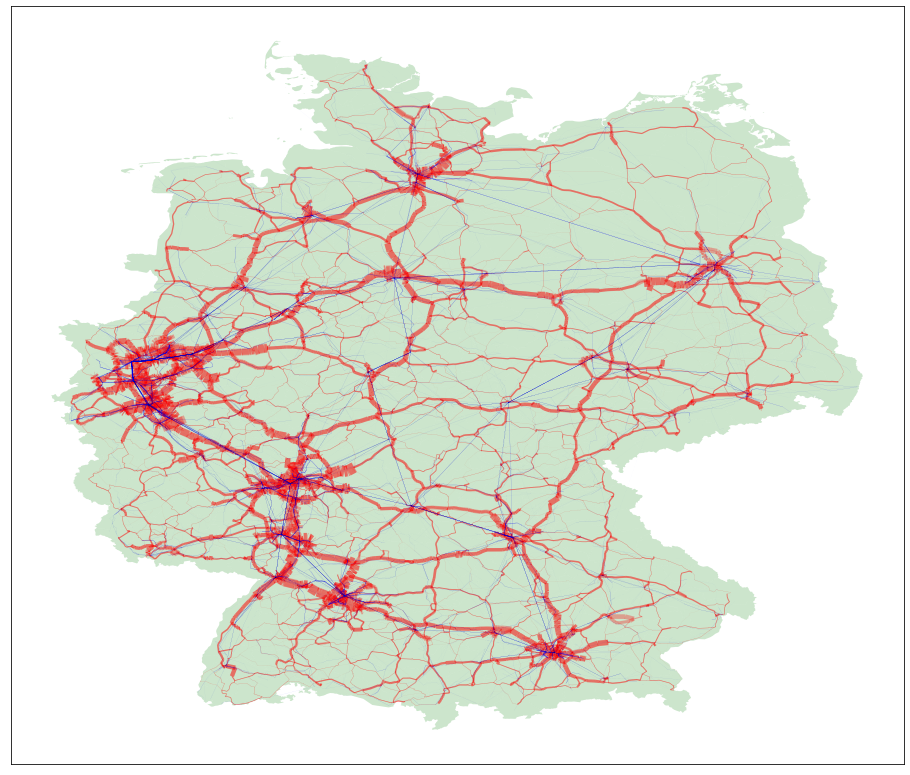

In [27]:
# Plot road and PT assignment
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / 35
sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))
plt.savefig(output_path + 'figures/network_load_all.png', dpi=300)

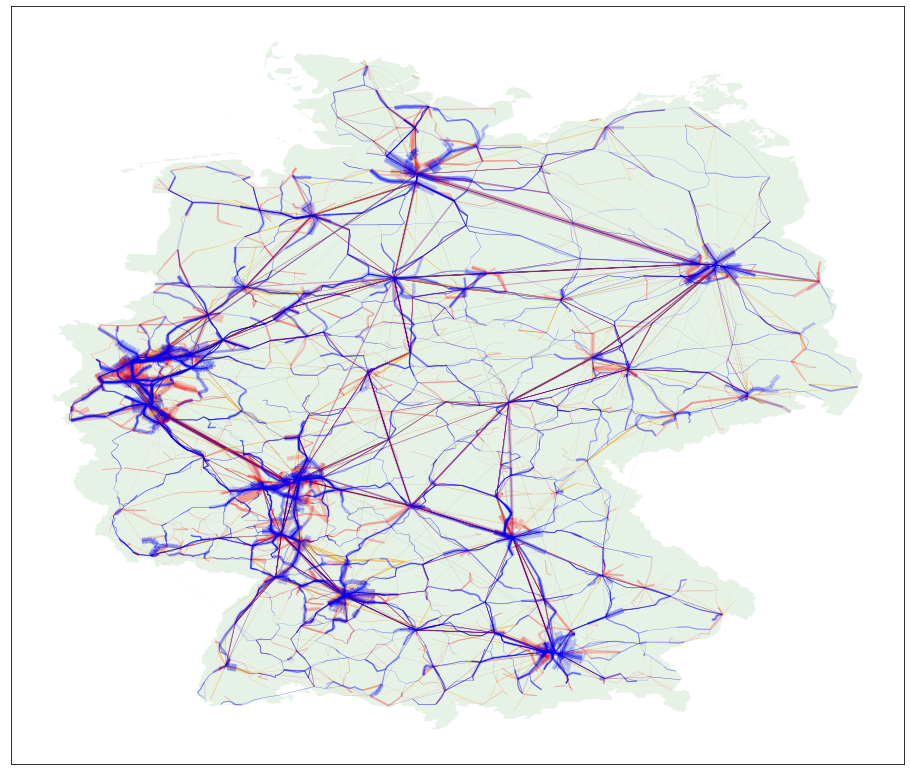

In [28]:
# Only PT
colors = sm.loaded_links['route_type'].map(
    {'rail': 'blue', 'rail_long': 'purple', 'rail_short': 'blue',
     'bus': 'red', 'subway': 'red', 'tram': 'red', 'ferry': 'red', 'funicular': 'red',
     'coach': 'orange', 'air': 'black', 'walk': 'grey'})
sm.loaded_links.plot(alpha=.2, color=list(colors),
    linewidth=list(sm.loaded_links['load']/sm.loaded_links['load'].max()*35),
    ax=sm.plot('zones', alpha=.1, color='green', figsize=(16,16)))
plt.savefig(output_path + 'figures/network_load_pt.png', dpi=300)

### Validation

In [29]:
# Total difference between volumes and loads
vol = sm.volumes.set_index(['origin', 'destination']).sum(axis=1).rename('vol')
diff = sm.los.groupby(['origin', 'destination']).agg({'volume': 'sum'}).merge(
    vol, left_index=True, right_index=True)
diff['diff'] = diff['vol'] - diff['volume']

In [30]:
diff['diff'].mean()

2.2816867321017848e-07

<AxesSubplot:>

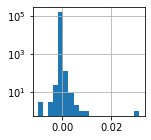

In [31]:
diff['diff'].hist(bins=20, log=True, figsize=(2,2))

In [32]:
# Summary of LoS table volumes
od_sum = sm.summary_od(costs=[])

In [33]:
od_sum.sample()

segment                    Fz1    Fz2    Fz3       Fz4        Fz6       root
sum                     volume volume volume    volume     volume     volume
origin destination mode                                                     
DE24D  DE723       rail    0.0    0.0    0.0  2.483351  37.958864  40.442216

In [34]:
# Add averages from following attributes
attrs = ['price', # EUR per person
         'time', # hours per trip
         'in_vehicle_time', # seconds per ride
         'length', # Meter distance
         'ntransfers'] # per trip
means = sm.los.groupby(['origin', 'destination', 'route_type'])[attrs].mean()
for attr in attrs:
    od_sum[('root', attr)] = means[attr]

In [35]:
# Convert units
od_sum[('root', 'length')] /= 1000
od_sum[('root', 'in_vehicle_time')] /= 3600

In [36]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[('root', 'length')]

In [37]:
# Load calibration dataset for modal split validation
mid2017 = pd.read_csv(network_path + 'mid2017_validation_normalised.csv')
mid2017.set_index('mode_model', drop=True, inplace=True)
mode_dict_mid = {1: 'rail', 2: 'rail',
                 3: 'bus', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid2017['mode_agg'] = [mode_dict_mid[i] for i in mid2017.index]

array([<AxesSubplot:ylabel='1'>, <AxesSubplot:ylabel='2'>,
       <AxesSubplot:ylabel='3'>, <AxesSubplot:ylabel='4'>,
       <AxesSubplot:ylabel='6'>], dtype=object)

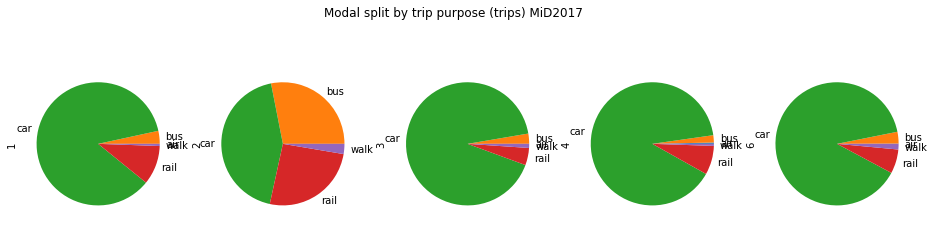

In [38]:
mid2017.groupby('mode_agg').sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (trips) MiD2017')

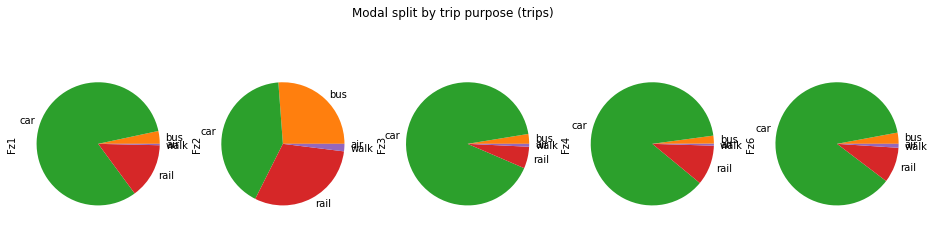

In [39]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')
plt.savefig(output_path + 'figures/modal_split_trips_segmented.png', dpi=300)

In [40]:
# MiD mode shares in percent
(mid2017.groupby('mode_agg').sum() / mid2017[['1','2','3','4','6']].sum() * 100).round(2)

1      2      3      4      6
mode_agg                                   
air        0.00   0.00   0.01   0.35   0.05
bus        3.40  28.10   2.67   1.90   3.10
car       85.75  43.49  91.72  89.62  89.03
rail      10.28  25.75   4.53   7.59   6.34
walk       0.57   2.66   1.08   0.54   1.48

In [41]:
# Model mode shares in percent
(od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum(axis=1) /
 od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].sum().droplevel('sum') * 100).round(2)

Fz1    Fz2    Fz3    Fz4    Fz6
mode                                   
air    0.00   0.00   0.00   0.04   0.00
bus    3.36  26.17   2.58   2.09   2.93
car   81.74  41.43  90.96  86.89  86.74
rail  14.54  30.44   5.71  10.49   9.30
walk   0.37   1.96   0.76   0.49   1.03

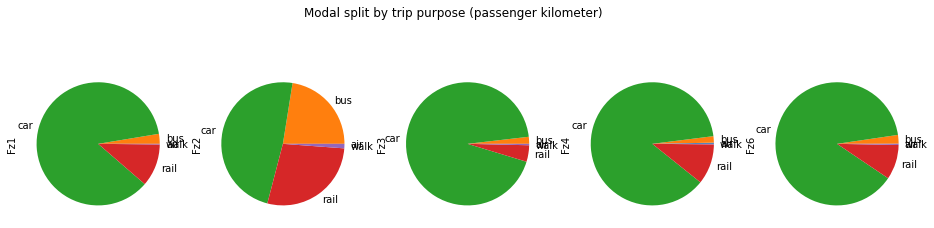

In [42]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')
plt.savefig(output_path + 'figures/modal_split_pkm_segmented.png', dpi=300)

In [43]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])

In [51]:
# Normalise model volumes
od = od_sum[[(seg, 'volume') for seg in sm.segments]
           ].unstack('mode').fillna(0).droplevel('sum', axis=1)
od = (od-od.min())/(od.max()-od.min()).max()
# Scale model and validation data to the same level
od = od * (vp2017.mean().mean() / od.mean().mean())

In [44]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 300, 1000]
distances = sm.car_los.drop_duplicates(['origin', 'destination']).set_index(
    ['origin', 'destination'])['length'] / 1000
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [53]:
# Cut matrices into distance classes
od['bins'] = pd.cut(od.merge(distances, how='left', left_index=True, right_index=True)['length'],
                    bins=bins, labels=labels)
vp2017['bins'] = pd.cut(vp2017.merge(distances, how='left', left_index=True, right_index=True)['length'],
                        bins=bins, labels=labels)

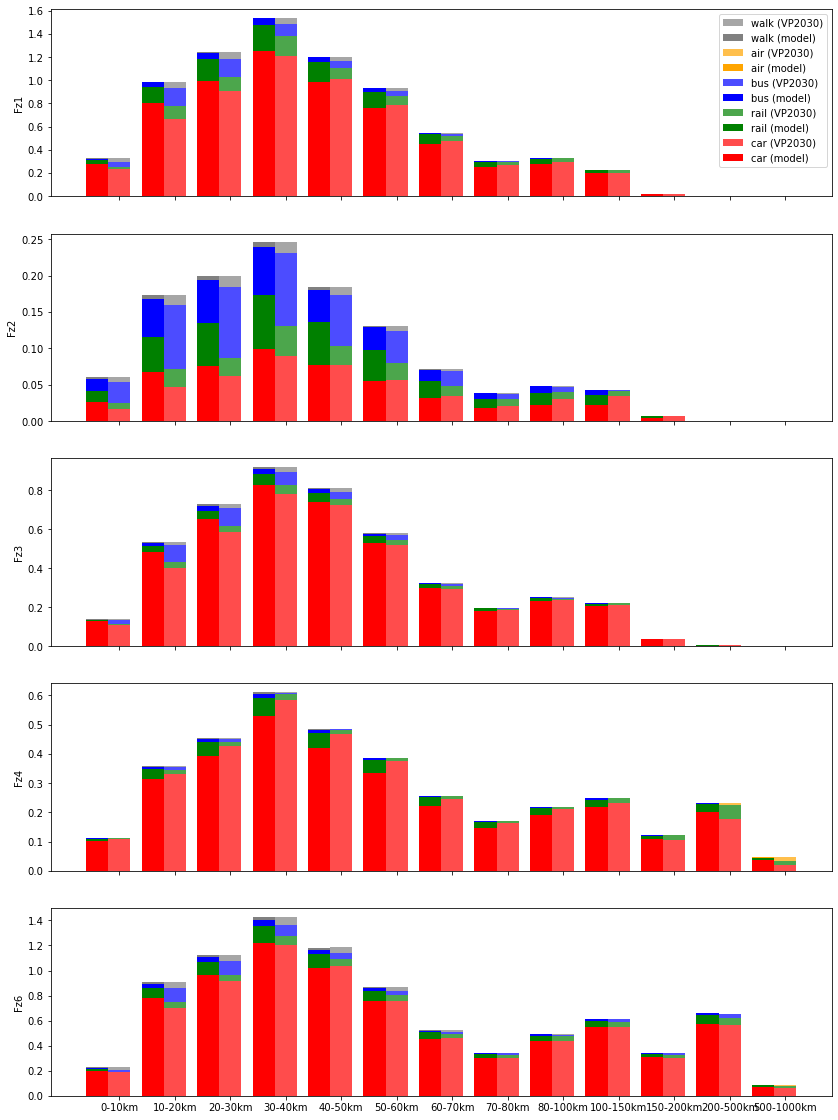

In [55]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(sm.segments), ncols=1,
                       figsize=(14,len(sm.segments)*4),
                       sharex='all', sharey='row')
width = 0.4
ind = np.arange(len(labels))
modes = ['car', 'rail', 'bus', 'air', 'walk']
colors = ['red', 'green', 'blue', 'orange', 'grey']
od_binned = od.groupby('bins').sum()
vp_binned = vp2017.groupby('bins').sum()
for seg in range(len(sm.segments)):
    model_vols = [od_binned[(sm.segments[seg], mode)] for mode in modes]
    vp_vols = [vp_binned[(sm.segments[seg], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            vp_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            vp_bottom = sum(vp_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(vp_vols[i]), bottom=vp_bottom, alpha=.7,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax[seg].set_ylabel(sm.segments[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
plt.savefig(output_path + 'figures/distance_validation_VP2030.png', dpi=300)

In [71]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
# Replace LAU codes with NUTS IDs
if not str(mid2017.loc[0, 'origin']).startswith('DE'):
    lau_nuts_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
    mid2017['origin'] = mid2017['origin'].astype(str).map(lau_nuts_dict)
    mid2017['destination'] = mid2017['destination'].astype(str).map(lau_nuts_dict)
    # Drop all other trips
    mid2017 = mid2017.loc[(mid2017['origin'].notna()) & (mid2017['destination'].notna())]
# Rename modes and purposes
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_vp'] = 'Fz' + mid2017['purpose_vp'].apply(str)

In [72]:
# Count observations by distance class
mid2017['length'] = mid2017.set_index(['origin', 'destination']).index.map(distances.to_dict())
mid2017['bins'] = pd.cut(mid2017['length'], bins=bins, labels=labels)
mid2017 = mid2017.groupby(['bins', 'mode_model', 'purpose_vp']).count()[
    ['origin']].unstack().unstack().fillna(0).droplevel(0, axis=1)

In [79]:
# Normalise and scale the dataset
mid2017 = (mid2017-mid2017.min())/(mid2017.max()-mid2017.min()).max()
mid2017 = mid2017 * (od_binned.mean().mean() / mid2017.mean().mean())

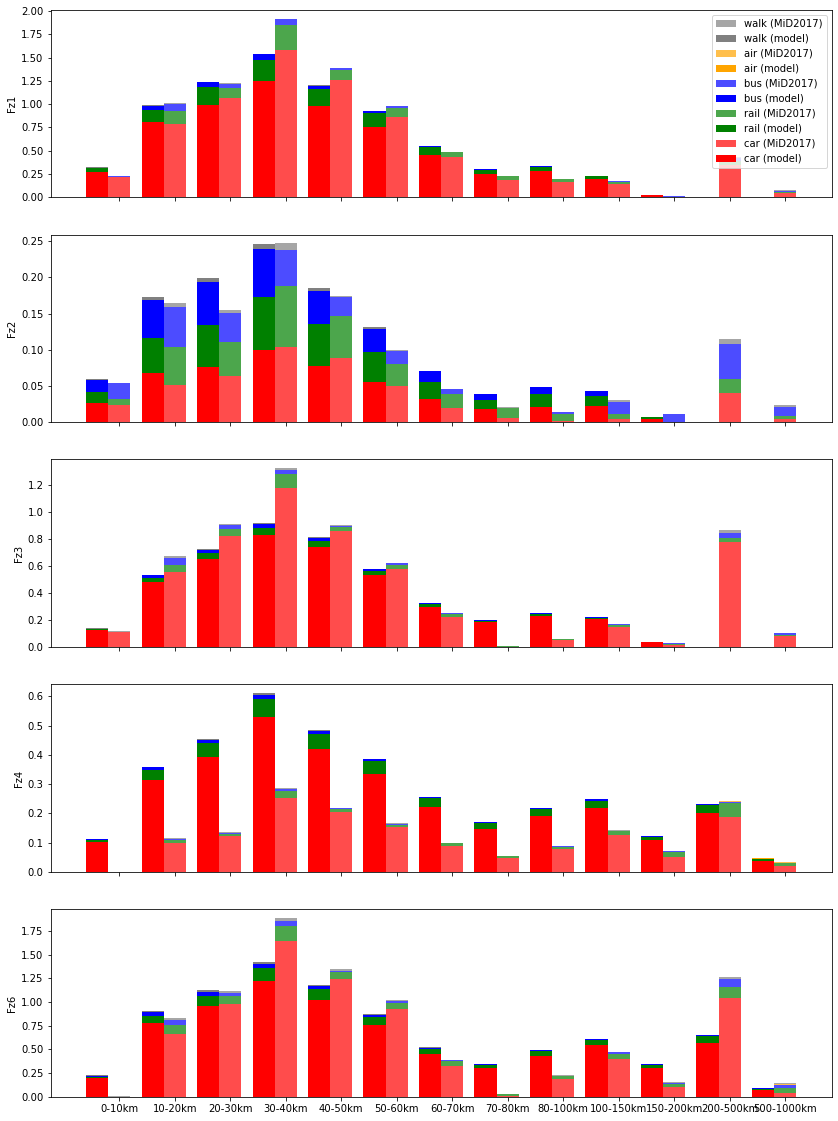

In [80]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(sm.segments), ncols=1,
                       figsize=(14,len(sm.segments)*4),
                       sharex='all', sharey='row')
for seg in range(len(sm.segments)):
    model_vols = [od_binned[(sm.segments[seg], mode)] for mode in modes]
    mid_vols = [mid2017[(sm.segments[seg], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            mid_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            mid_bottom = sum(mid_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(mid_vols[i]), bottom=mid_bottom, alpha=.7,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
    ax[seg].set_ylabel(sm.segments[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
plt.savefig(output_path + 'figures/distance_validation_MiD2017.png', dpi=300)

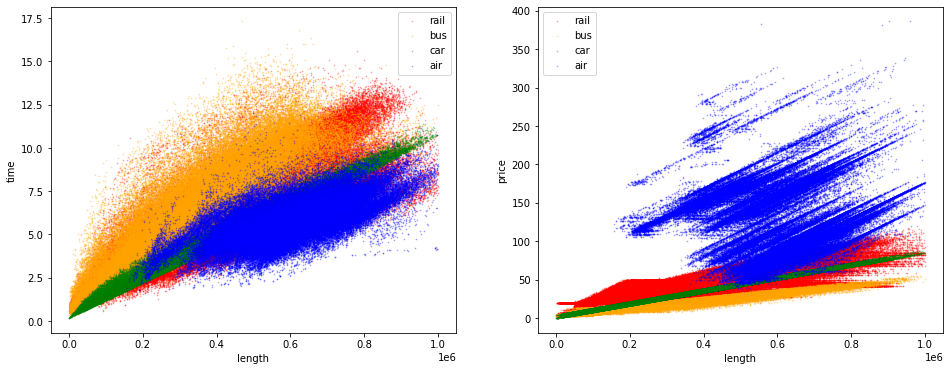

In [39]:
# How do the LoS attributes look like again?
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
c_dict = {'rail': 'red', 'bus': 'orange', 'car': 'green', 'air': 'blue'}
sm.los['length'] = sm.los['length'] / 1000
for m in c_dict.keys():
    sm.los.loc[sm.los['route_type']==m].plot(
        ax=ax[0], kind='scatter', x='length', y='time', s=.5, c=c_dict[m], alpha=.3, label=m)
    sm.los.loc[sm.los['route_type']==m].plot(
        ax=ax[1], kind='scatter', x='length', y='price', s=.5, c=c_dict[m], alpha=.3, label=m)
plt.legend()
plt.savefig(output_path + 'figures/LoS_attributes.png', dpi=300)
sm.los['length'] = sm.los['length'] * 1000

### Excel export

What do we need as outputs for energy and emission modelling? Most commonly, energy system models minimise total system cost under the constraint of emissions reduction towards a given goal. Costs include investments into vehicles (sometimes even infrastructure) and operating cost of these vehicles. Demand for transport is exogenously defined as activity rates per vehicle technology type in each time step. This model can contribute:
* passenger kilometer per mode and zone
* user cost, which can be translated into operating cost

In [40]:
# Keep only the aggregation of all purposes
od = od_sum.loc[:, 'root']

In [41]:
# Aggregated modal split in million pkm
od.groupby(level=2).sum(axis=1)['pkm'] / 1e6

mode
air        641.012885
bus      25221.434688
car     792817.292672
rail     88126.441886
walk      2565.930138
Name: pkm, dtype: float64

In [42]:
# Reduce table size by mapping origin and destination to bigger zones
od.reset_index(drop=False, inplace=True)
od['origin'] = od['origin'].str[:3] # NUTS1
od['destination'] = od['destination'].str[:3]

In [43]:
# Calculate weighted averages by zone aggregation
weighted_av = lambda x: np.average(x, weights=od.loc[x.index, 'volume'])
od = od.groupby(['origin', 'destination', 'mode']).agg(
    volumes=('volume', 'sum'),
    price=('price', weighted_av),
    time=('time', weighted_av),
    in_vehicle_time=('in_vehicle_time', weighted_av),
    length=('length', weighted_av))

In [44]:
with pd.ExcelWriter(output_path + 'inter_zone.xlsx') as writer:  
    od.to_excel(writer, sheet_name='od')

## Save model

In [45]:
sm.to_json(model_path + 'de_assignment', only_attributes=[
    'loaded_links', 'loaded_nodes', 'road_links'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [03:21<00:00,  5.29s/it]
